In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

### 1. Data preparation

In [2]:
BATCH_SIZE = 256

transform = transforms.Compose([transforms.ToTensor()])

train_val_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_size = int(len(train_val_dataset) * 0.8)
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)

torch.Size([256, 1, 28, 28])


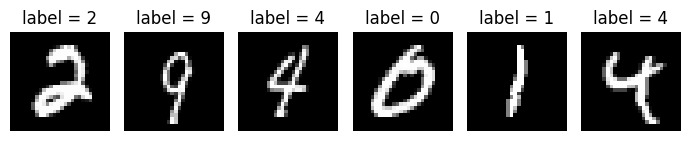

In [3]:
samples = next(iter(train_dataloader))

print(samples[0].shape)

plt.figure(figsize=(7, 2))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    img = samples[0][i].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'label = {samples[1][i]}')
    plt.axis('off')
plt.tight_layout()
plt.show();

### 2. Model Architecture

In [4]:
class LinearModel(nn.Module):

    def __init__(self, ):
        super(LinearModel, self).__init__()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, inputs, training=False):

        x = self.flatten(inputs) # (B, 1 * 28 * 28)
        x = F.relu(self.linear1(x)) # (B, 32)
        output = self.linear2(x) 
        return output # (B, 10)

In [5]:
# torch.nn.CrossEntropyLoss = softmax + cross-entropy
# torch.nn.BCELoss = cross-entropy
# torch.nn.BCEWithLogitsLoss = sigmoid + cross-entropy

EPOCHS = 10
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # M1, M2 chip

model = LinearModel()
loss_fn = nn.CrossEntropyLoss() # reduction = mean
optimizer = torch.optim.Adam(model.parameters())

list_train_loss = []
list_val_loss = []
list_acc = []

model = model.to(device)
for epoch in tqdm(range(EPOCHS), desc='MODEL TRAINING & EVALUATION'):

    # Training step
    model.train()
    train_loss = 0.0
    for data, label in train_dataloader:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, label)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_dataloader) # loss_fn reduction = Mean
    list_train_loss.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, label in val_dataloader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, label)

            val_loss += loss.cpu().detach().numpy()
        val_loss /= len(val_dataloader) # loss_fn reduction = mean
        list_val_loss.append(val_loss)
    print('=' * 15)
    print('Epoch : {:.4f}, Train_loss : {:.4f}, valid_loss : {:.4f}'.format(epoch+1, train_loss, val_loss))  


# Test step
model.eval()
total_correct = 0.0
with torch.no_grad():
    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        outputs = model(data) # (batch, 10)
        prediction = torch.argmax(outputs, dim=-1).type(label.dtype) # (batch, )

        correct = torch.eq(prediction, label).sum()
        total_correct += correct.cpu().detach().numpy()

    total_correct /= len(test_dataloader.dataset)
    list_acc.append(total_correct)
print('=' * 15)
print('=' * 15)
print('Test_accuracy : {:.2f}'.format(total_correct * 100))
print('Complete')


MODEL TRAINING & EVALUATION:  10%|█         | 1/10 [00:02<00:19,  2.15s/it]

Epoch : 1.0000, Train_loss : 0.8309, valid_loss : 0.3834


MODEL TRAINING & EVALUATION:  20%|██        | 2/10 [00:04<00:16,  2.10s/it]

Epoch : 2.0000, Train_loss : 0.3345, valid_loss : 0.2997


MODEL TRAINING & EVALUATION:  30%|███       | 3/10 [00:06<00:14,  2.08s/it]

Epoch : 3.0000, Train_loss : 0.2797, valid_loss : 0.2682


MODEL TRAINING & EVALUATION:  40%|████      | 4/10 [00:08<00:12,  2.07s/it]

Epoch : 4.0000, Train_loss : 0.2496, valid_loss : 0.2482


MODEL TRAINING & EVALUATION:  50%|█████     | 5/10 [00:10<00:10,  2.05s/it]

Epoch : 5.0000, Train_loss : 0.2251, valid_loss : 0.2296


MODEL TRAINING & EVALUATION:  60%|██████    | 6/10 [00:12<00:08,  2.05s/it]

Epoch : 6.0000, Train_loss : 0.2043, valid_loss : 0.2144


MODEL TRAINING & EVALUATION:  70%|███████   | 7/10 [00:14<00:06,  2.04s/it]

Epoch : 7.0000, Train_loss : 0.1873, valid_loss : 0.1999


MODEL TRAINING & EVALUATION:  80%|████████  | 8/10 [00:16<00:04,  2.04s/it]

Epoch : 8.0000, Train_loss : 0.1723, valid_loss : 0.1882


MODEL TRAINING & EVALUATION:  90%|█████████ | 9/10 [00:18<00:02,  2.04s/it]

Epoch : 9.0000, Train_loss : 0.1599, valid_loss : 0.1814


MODEL TRAINING & EVALUATION: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

Epoch : 10.0000, Train_loss : 0.1495, valid_loss : 0.1771


Test_accuracy : 95.20
Complete


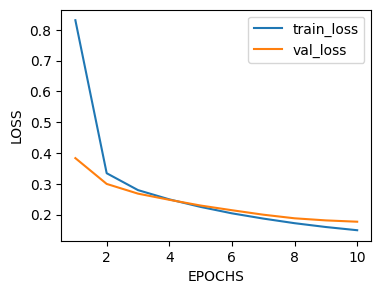

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(range(1, len(list_train_loss)+1), list_train_loss, label='train_loss')
plt.plot(range(1, len(list_train_loss)+1), list_val_loss, label='val_loss')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.legend()
plt.show()